In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import copy

In [2]:
## See Giamarchi, QuantumPhysicsInOneDimension
## p.146 Sec.5.1.3 Eqs.(5.37-5.39)
## p.404 Appendix F
##
## l: number of sites L
## n: number of particles N, half filling is N = L/2
## u: interaction V of a spinless fermion model
##
## [spin] Jxy/2, Jz, -h
## [fermion] -t, V, -mu
## [correspondence] -t = Jxy/2, V = Jz
## ( [correspondence after c_i -> (-1)^i c_i] t = Jxy/2, V = Jz )
## [energy scale] Delta = Jz/Jxy = 1 <--> Delta = V/(-2t) = 1
##
## [parameter choice] t = +1 (<--> Jxy = -2), V = -u, Delta = V/(-2t) = +u/2
## [original choice]
## temp1 = (-u) * np.sin(0.5 * (psi[i] - psi[j]))
## temp2 = temp1/( - np.cos(0.5 * (psi[i] + psi[j])) + (-u) * np.cos(0.5 * (psi[i] - psi[j])) )
## [equivalent choice used in this code]
## temp1' = u * np.sin(0.5 * (psi[i] - psi[j]))
## temp2' = temp1'/( np.cos(0.5 * (psi[i] + psi[j])) + u * np.cos(0.5 * (psi[i] - psi[j])) )
## (temp1' = -temp1)

In [3]:
@jit(nopython=True)
def update_psi(l,n,u,phi,intgr,p,psi): # p: new psi, psi: old psi
    for i in range(n):
        p[i] = 2.0 * np.pi * intgr[i] + phi
        for j in range(n):
            temp = u * np.sin(0.5 * (psi[i] - psi[j]))
            temp = temp/( np.cos(0.5 * (psi[i] + psi[j])) + u * np.cos(0.5 * (psi[i] - psi[j])) )
            p[i] += 2.0 * np.arctan(temp)
        p[i] /= l
    return 0

@jit(nopython=True)
def calc_psi(l,n,u,phi):
    p0 = np.zeros(n)
    p1 = np.zeros(n)
    p2 = np.zeros(n)
    intgr = np.array([(i+1.0)-0.5*(n+1.0) for i in range(n)]) ## for even and odd n
    niter = 100
    eps = 1e-12
    for k in range(niter):
        # Steffensen's method
        update_psi(l,n,u,phi,intgr,p1,p0)
        update_psi(l,n,u,phi,intgr,p2,p1)
        x1 = p2 - p1
        x2 = p2 - 2.0*p1 + p0
        if np.linalg.norm(x2) < eps:
            p0 = p2[:]
            break
        p3 = p2 - x1.dot(x2)/x2.dot(x2) * x1
        if np.linalg.norm(p3-p0) < eps:
            p0 = p3[:]
            break
#        print(k,p0,np.linalg.norm(p3-p0))
#        print(k,p0[0],np.linalg.norm(p3-p0))
        p0 = p3[:]
    if k==niter-1:
        print("### not converged: l,n,u,phi,iter",l,n,u,phi,k+1)
    return p0,k+1

@jit(nopython=True)
def calc_energy(l,n,u,p):
    ener = 0.0
    for i in range(n):
        ener -= 2.0 * (u + np.cos(p[i]))
    ener += 0.5 * u * l
    return ener

In [4]:
@jit(nopython=True)
def calc_llparameter(l,n,dblu):
    u = 0.5 * dblu
    # calculation of compressibility
    phi = 0.0 # zero external flux for compressibility
    p0, k0 = calc_psi(l,n,u,phi)
    ener0 = calc_energy(l,n,u,p0)
    pp2, kp2 = calc_psi(l,n+2,u,phi)
    enerp2 = calc_energy(l,n+2,u,pp2)
    pm2, km2 = calc_psi(l,n-2,u,phi)
    enerm2 = calc_energy(l,n-2,u,pm2)
    uoverk = 0.25 * l * (enerp2 + enerm2 - 2.0 * ener0) / np.pi
    # calculation of chemical potential
    mu = 0.25 * (enerp2 - enerm2)
    # calculation of the stiffness
    delphi = 0.01 # flux of 0.01 hopping which is small enough
    p, k = calc_psi(l,n,u,delphi)
    ener = calc_energy(l,n,u,p)
    utimesk = 2.0 * np.pi * l * (ener-ener0)/delphi**2 # stiffness
    llu = np.sqrt(uoverk*utimesk)
    llK = np.sqrt(utimesk/uoverk)
    return [l,n,dblu,u,mu,llu,llK,ener0,k0,enerp2,kp2,enerm2,km2,ener,k]

In [5]:
l = 102
#l = 100
dblus = np.linspace(0.0,3.5,31)
#dblus = np.linspace(0.0,4.0,41)
ns = np.arange(2,int(l*0.46)) # 2<=n<=l
#ns = np.arange(2,l//2+1) # 2<=n<=l
#ns = np.arange(2,l//2) # 2<=n<=l
data = []
for dblu in dblus:
    for n in ns:
        data.append(calc_llparameter(l,n,dblu))
data = np.array(data)
print(data)

### not converged: l,n,u,phi,iter 102 47 1.6916666666666667 0.0 100
### not converged: l,n,u,phi,iter 102 47 1.75 0.0 100
[[ 102.            2.            0.         ...    1.
    -3.99810286    2.        ]
 [ 102.            3.            0.         ...    1.
    -5.99241329    2.        ]
 [ 102.            4.            0.         ...    2.
    -7.98103955    2.        ]
 ...
 [ 102.           43.            3.5        ...    9.
  -105.71128921   10.        ]
 [ 102.           44.            3.5        ...   10.
  -107.77564916   11.        ]
 [ 102.           45.            3.5        ...   10.
  -109.63408832   11.        ]]


31
44
n [[ 2.  3.  4. ... 43. 44. 45.]
 [ 2.  3.  4. ... 43. 44. 45.]
 [ 2.  3.  4. ... 43. 44. 45.]
 ...
 [ 2.  3.  4. ... 43. 44. 45.]
 [ 2.  3.  4. ... 43. 44. 45.]
 [ 2.  3.  4. ... 43. 44. 45.]]
dblu [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.11666667 0.11666667 0.11666667 ... 0.11666667 0.11666667 0.11666667]
 [0.23333333 0.23333333 0.23333333 ... 0.23333333 0.23333333 0.23333333]
 ...
 [3.26666667 3.26666667 3.26666667 ... 3.26666667 3.26666667 3.26666667]
 [3.38333333 3.38333333 3.38333333 ... 3.38333333 3.38333333 3.38333333]
 [3.5        3.5        3.5        ... 3.5        3.5        3.5       ]]
llK [[1.00015812 1.00015813 1.00015811 ... 1.00015813 1.0001581  1.00015813]
 [0.99772921 0.99674319 0.99571536 ... 0.9654949  0.96522653 0.96499277]
 [0.99555443 0.99368689 0.99174036 ... 0.93329178 0.93273878 0.93225509]
 ...
 [0.97286584 0.96189379 0.95049028 ... 0.51234024 0.49843307 0.48347094]
 [0.97250468 0.96138908 0.94983757 ... 0.50530505 

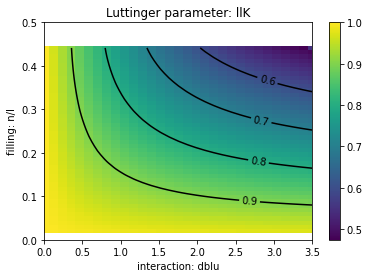

In [6]:
## l,n,dblu,u,mu,llu,llK,ener0,k0,enerp2,kp2,enerm2,km2,ener,k
y = len(ns)
x = len(dblus)
print(x)
print(y)
print("n",data[:,1].reshape(x,y))
print("dblu",data[:,2].reshape(x,y))
print("llK",data[:,6].reshape(x,y))

llK = copy.deepcopy(data[:,6].reshape(x,y).T)
#print(llK)
mask = (llK>1.1) | (llK<-0.1)
#print(mask)
llK[mask] = np.nan
print("llK",data[:,6].reshape(x,y))

llKcntr = copy.deepcopy(data[:,6].reshape(x,y).T)
mask2 = (llKcntr>1.0) | (llKcntr<0.55)
llKcntr[mask2] = np.nan

plt.title("Luttinger parameter: llK")
plt.xlabel("interaction: dblu")
plt.ylabel("filling: n/l")
#plt.xlim(0,4)
plt.xlim(0,3.5)
plt.ylim(0,0.5)
cntr = plt.contour(dblus,ns/l,llKcntr,levels=[0.6,0.7,0.8,0.9],colors="black")
cntr.clabel(fmt='%1.1f')
plt.pcolormesh(dblus,ns/l,llK,shading="auto")
plt.colorbar()

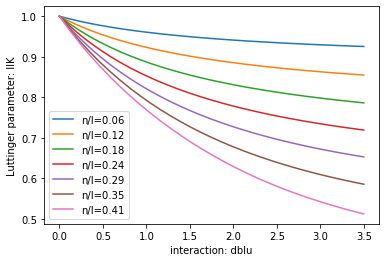

In [7]:
## l,n,dblu,u,mu,llu,llK,ener0,k0,enerp2,kp2,enerm2,km2,ener,k
plt.xlabel("interaction: dblu")
plt.ylabel("Luttinger parameter: llK")
for i in range(4,len(ns)-1,6):
    plt.plot(dblus,llK[i],label="n/l={:.2f}".format(ns[i]/l))
plt.legend()

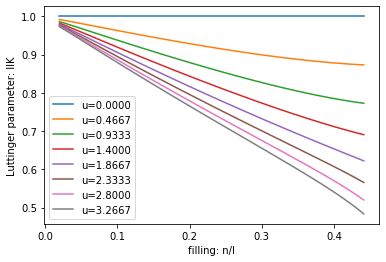

In [8]:
## l,n,dblu,u,mu,llu,llK,ener0,k0,enerp2,kp2,enerm2,km2,ener,k
plt.xlabel("filling: n/l")
plt.ylabel("Luttinger parameter: llK")
for i in range(0,len(dblus)-1,4):
    plt.plot(ns/l,llK[:,i],label="u={:.4f}".format(dblus[i]))
plt.legend()